## Dependencias

In [1]:
import numpy as np
import pandas as pd
import re
import os


from collections import Counter
from functools import reduce

import spacy
from spacy.lang.es import Spanish
from spacy.lang.es.stop_words import STOP_WORDS
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score


## Carga de datos de texto

In [2]:
ruta = 'data/opiniones_diplo/'
l = os.listdir(ruta)

df = pd.concat(map(lambda x:pd.read_csv(os.path.join(ruta,x)),l),ignore_index=True)
df.shape

(693, 9)

In [3]:
df.head(2)

,Timestamp,¿Cómo calificas la calidad de los contenidos del curso?,"¿Cómo calificas la calidad de los materiales(apuntes, códigos, datos, etc.?",¿Cómo calificas el nivel de dificultad de los contenidos del curso?,¿Cómo calificas la calidad del ponente?,¿Cómo calificas el nivel de dificultad de la evaluación?,¿Cómo calificas la calidad de las prácticas en clase?,"En general, ¿Cuántas estrellas darías al módulo?","Por favor, emite tu libre opinión sobre el módulo en general (instructor, material, contenido, etc.)"
0,2021/04/15 8:37:05 PM EST,5,5,4,5,5,5,5,El mejor curso que he tomado de ciencias de da...
1,2021/04/15 8:37:43 PM EST,5,5,5,5,4,5,5,Me gustaria un poco mas de bibliografia para c...


## Preprocesamiento

In [4]:
df = df[['Por favor, emite tu libre opinión sobre el módulo en general (instructor, material, contenido, etc.)',
        'En general, ¿Cuántas estrellas darías al módulo?']]
df.columns = ['texto','sentimiento']

In [5]:
df.head()

,texto,sentimiento
0,El mejor curso que he tomado de ciencias de da...,5
1,Me gustaria un poco mas de bibliografia para c...,5
2,Me gusta mucho que sea mucho contenido practico,5
3,Excelente el modulo,5
4,"Las explicaciones fueron muy claras, se cubrie...",5


### Minúsculas

In [6]:
df['texto'] = df['texto'].map(str.lower)

In [7]:
df.head()

,texto,sentimiento
0,el mejor curso que he tomado de ciencias de da...,5
1,me gustaria un poco mas de bibliografia para c...,5
2,me gusta mucho que sea mucho contenido practico,5
3,excelente el modulo,5
4,"las explicaciones fueron muy claras, se cubrie...",5


### Quitar stopwords

In [13]:
STOP_WORDS = STOP_WORDS.union(set(stopwords.words('spanish')))

In [14]:
df['texto'] = df['texto'].map(lambda x: [w for w in x.split(' ') if w not in STOP_WORDS]).apply(" ".join)
df.head()

,texto,sentimiento
0,curso tomado ciencias datos. bueno.,5
1,"gustaria bibliografia tema, peros basico.",5
2,gusta contenido practico,5
3,excelente modulo,5
4,"explicaciones claras, cubrieron establecidas c...",5


### Lematización (buscar la raíz de la palabra)

In [15]:
spacy.cli.download("es_core_news_sm")
nlp = spacy.load('es_core_news_sm')

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [21]:
df['texto'] = df['texto'].map(nlp).map(lambda x:[w.lemma_ for w in x]).apply(" ".join)
df.head()

,texto,sentimiento
0,curso tomado ciencia dato . bueno .,5
1,"gustaria bibliografio tema , pero basico .",5
2,gustar contenido practico,5
3,excelente modulo,5
4,"explicación claro , cubrir establecido conside...",5


### Quitar puntuación

In [23]:
"""
re.sub: Patrón, sustitución, texto, juego de caracteres

r' --> Raw String
^ -->  Empieza por..
\w --> alfanuméricos
\s --> espacios
[] --> Incluír solo los caracteres del patrón indicado
"""

df['texto'] = df['texto'].map(lambda x:re.sub(r'[^\w\s]','',x, re.UNICODE))

In [24]:
df.head()

,texto,sentimiento
0,curso tomado ciencia dato bueno,5
1,gustaria bibliografio tema pero basico,5
2,gustar contenido practico,5
3,excelente modulo,5
4,explicación claro cubrir establecido consider...,5


### Quitar hapaxes (tokens con frecuencia 1)

In [25]:
conteos = Counter(reduce(lambda x,y:x+y,df['texto'].map(lambda x:x.split(' '))))

In [27]:
hapaxes = [t for t,count in conteos.items() if count == 1 or t == '']
df['texto'] = df['texto'].map(lambda x:[w for w in x.split(' ') if w not in hapaxes]).apply(" ".join)
df.head()

,texto,sentimiento
0,curso tomado ciencia dato bueno,5
1,tema pero,5
2,gustar contenido practico,5
3,excelente modulo,5
4,explicación claro cubrir establecido considera...,5


## Tokenizar texto en tensores

### Tamaño del vocabulario

In [28]:
vocab = pd.Series(Counter(reduce(lambda x,y:x+y,df['texto'].map(lambda x:x.split(' '))))).sort_values(ascending=False).to_frame()
vocab.reset_index(inplace=True)
vocab.columns = ['token','count']
vocab['pct'] = vocab['count']/vocab['count'].sum()
vocab.describe()

,count,pct
count,906.000000,906.000000
mean,9.842163,0.001104
std,21.684743,0.002432
min,2.000000,0.000224
25%,2.000000,0.000224
50%,4.000000,0.000449
75%,8.750000,0.000981
max,316.000000,0.035438


### Tokenizar

In [30]:
tk = tf.keras.preprocessing.text.Tokenizer(num_words=300, lower=True,split=' ')
tk.fit_on_texts(df['texto'])
X = tk.texts_to_sequences(df['texto'])
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(693, 125)

## Variable Objetivo

In [35]:
df['sentimiento'].value_counts(1).sort_index(ascending=False)

5    0.678211
4    0.222222
3    0.063492
2    0.024531
1    0.011544
Name: sentimiento, dtype: float64

In [37]:

y = np.array(df['sentimiento']<4).astype(int)

y.mean()

0.09956709956709957

## Partición para entrenamiento

In [38]:
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.9)
Xt.shape,Xv.shape

((623, 125), (70, 125))

## Configuración entrenamiento

In [62]:
tam_vocab = len(tk.word_index)
print(tam_vocab)
tam_vector_embed = 30
model = Sequential()
model.add(Embedding(tam_vocab, tam_vector_embed,     
                                     input_length=Xt.shape[1]) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(10, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
print(model.summary())

898
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 125, 30)           26940     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 125, 30)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 28,591
Trainable params: 28,591
Non-trainable params: 0
_________________________________________________________________
None


## Entrenamiento

In [63]:
historia = model.fit(Xt,yt,
                  validation_split=0.3, epochs=100, batch_size=25,shuffle=True)

Epoch 1/100
18/18 [==============================] - 7s 297ms/step - loss: 0.6669 - accuracy: 0.7752 - val_loss: 0.6311 - val_accuracy: 0.8824
Epoch 2/100
18/18 [==============================] - 5s 279ms/step - loss: 0.5686 - accuracy: 0.9174 - val_loss: 0.4896 - val_accuracy: 0.8824
Epoch 3/100
18/18 [==============================] - 5s 269ms/step - loss: 0.3895 - accuracy: 0.9197 - val_loss: 0.3561 - val_accuracy: 0.8824
Epoch 4/100
18/18 [==============================] - 5s 287ms/step - loss: 0.3172 - accuracy: 0.9197 - val_loss: 0.3696 - val_accuracy: 0.8824
Epoch 5/100
18/18 [==============================] - 5s 287ms/step - loss: 0.3048 - accuracy: 0.9197 - val_loss: 0.3760 - val_accuracy: 0.8824
Epoch 6/100
18/18 [==============================] - 5s 297ms/step - loss: 0.3075 - accuracy: 0.9197 - val_loss: 0.3695 - val_accuracy: 0.8824
Epoch 7/100
18/18 [==============================] - 5s 300ms/step - loss: 0.2872 - accuracy: 0.9197 - val_loss: 0.3674 - val_accuracy: 0.8824

Epoch 58/100
18/18 [==============================] - 6s 319ms/step - loss: 0.0428 - accuracy: 0.9908 - val_loss: 0.6703 - val_accuracy: 0.8824
Epoch 59/100
18/18 [==============================] - 6s 312ms/step - loss: 0.0492 - accuracy: 0.9885 - val_loss: 0.6687 - val_accuracy: 0.8824
Epoch 60/100
18/18 [==============================] - 6s 335ms/step - loss: 0.0456 - accuracy: 0.9862 - val_loss: 0.6626 - val_accuracy: 0.8824
Epoch 61/100
18/18 [==============================] - 6s 307ms/step - loss: 0.0479 - accuracy: 0.9908 - val_loss: 0.6600 - val_accuracy: 0.8717
Epoch 62/100
18/18 [==============================] - 6s 314ms/step - loss: 0.0370 - accuracy: 0.9977 - val_loss: 0.6788 - val_accuracy: 0.8770
Epoch 63/100
18/18 [==============================] - 6s 339ms/step - loss: 0.0475 - accuracy: 0.9931 - val_loss: 0.6739 - val_accuracy: 0.8717
Epoch 64/100
18/18 [==============================] - 6s 324ms/step - loss: 0.0358 - accuracy: 0.9954 - val_loss: 0.6968 - val_accuracy:

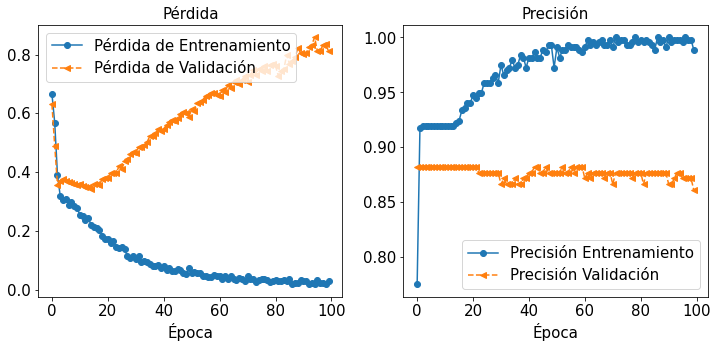

In [64]:
historia = historia.history
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(historia['loss'],'-o',label='Pérdida de Entrenamiento')
ax.plot(historia['val_loss'],'--<',label='Pérdida de Validación')
ax.set_title('Pérdida',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(historia['accuracy'],'-o',label='Precisión Entrenamiento')
ax.plot(historia['val_accuracy'],'--<',label='Precisión Validación')
ax.set_title('Precisión',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
plt.show()

## Prueba del modelo

In [65]:
yt_pred = model.predict(Xt)
yt_pred = np.array([int(x[0]>=0.5) for x in yt_pred])
yv_pred = model.predict(Xv)
yv_pred = np.array([int(x[0]>=0.5) for x in yv_pred])

In [66]:
yt_score =np.array([x[0] for x in model.predict(Xt)])
yv_score =np.array([x[0] for x in model.predict(Xv)])

In [67]:
accuracy_score(y_true=yt,y_pred=yt_pred),accuracy_score(y_true=yv,y_pred=yv_pred)

(0.9582664526484751, 0.8142857142857143)

In [68]:
roc_auc_score(y_true=yt,y_score=yt_score),roc_auc_score(y_true=yv,y_score=yv_score)

(0.8875767156406917, 0.5804597701149425)

In [69]:
for i in range(len(yv)):
    if yv[i] == 1:
        print(tk.sequences_to_texts(Xv)[i],'\t',yv[i],end='\n\n')

contenido modulo ver interesante tanto tema módulo anterior caso temario principio forma evaluación hacer módulo general material caso práctico material teórico herramienta útil módulo repasar visto clase buscar material curso considerar clase tener 	 1

mucho compartir material yo práctico sentir aplicar aprendido módulo necesitar estudiar quedar claro 	 1

considerar tema tiempo concepto forma adecuado ponente ocasión perder clase contar adecuado clase ponente entrar persona el presentación ayudar entender modelo formar sencillo 	 1

dejar proyecto grupo deber alumno él además perder saber mucho profesor gustar módulo profesor preparado 	 1

curso contenido ponente buen sentir ponente falta más preparado clase ir código error modulo teórico enfoque dar parecer ejercicio clase código explicar gracias dedicación 	 1

tema visto módulo dominar tema 	 1

sentir práctico complicado desarrollar práctico principio clase profe querer enseñar forma enseñar red neuronal mostrar tema considerar